### Importing relevent libraries

In [1]:
import os
import PIL
import PIL.Image
from pathlib import Path
import tensorflow as tf
import pandas as pd
from livelossplot import PlotLossesKerasTF
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.8.3


Check if GPU is availabl.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Loading data and creating datasets

In [3]:
os.chdir("..")

In [4]:
# Creating paths with data
DATA_DIR = Path('data')
DATA_DIR_TRAIN = DATA_DIR / 'train'
DATA_DIR_TEST = DATA_DIR / 'test_kaggle'

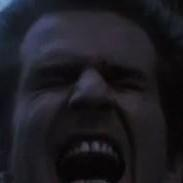

In [5]:
# Checking traim path
anger = list(DATA_DIR_TRAIN.glob('anger/*'))
PIL.Image.open(str(anger[0]))

In [6]:
# Folders with images are structured by classes, so we can use image_dataset_from_directory.
BATCH_SIZE = 32
IMG_HEIGHT = 320
IMG_WIDTH = 320

train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR_TRAIN,
                                                       label_mode='categorical',
                                                       validation_split=0.2,
                                                       subset='training',
                                                       seed=0,
                                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       batch_size=BATCH_SIZE)

valid_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR_TRAIN,
                                                       label_mode='categorical',
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=0,
                                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       batch_size=BATCH_SIZE)

Found 50047 files belonging to 9 classes.
Using 40038 files for training.
Found 50047 files belonging to 9 classes.
Using 10009 files for validation.


In [7]:
# Checking classes
class_names = train_ds.class_names
print(class_names)

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'uncertain']


In [8]:
emotion_mapping = {k: v for v, k in enumerate(class_names)}
emotion_mapping

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7,
 'uncertain': 8}

In [9]:
# We will use ResNet50 pretrained model so we need to preprocess data
def preprocess(images, labels):
    return tf.keras.applications.resnet50.preprocess_input(images), labels

In [10]:
train_ds = train_ds.map(preprocess)
valid_ds = valid_ds.map(preprocess)

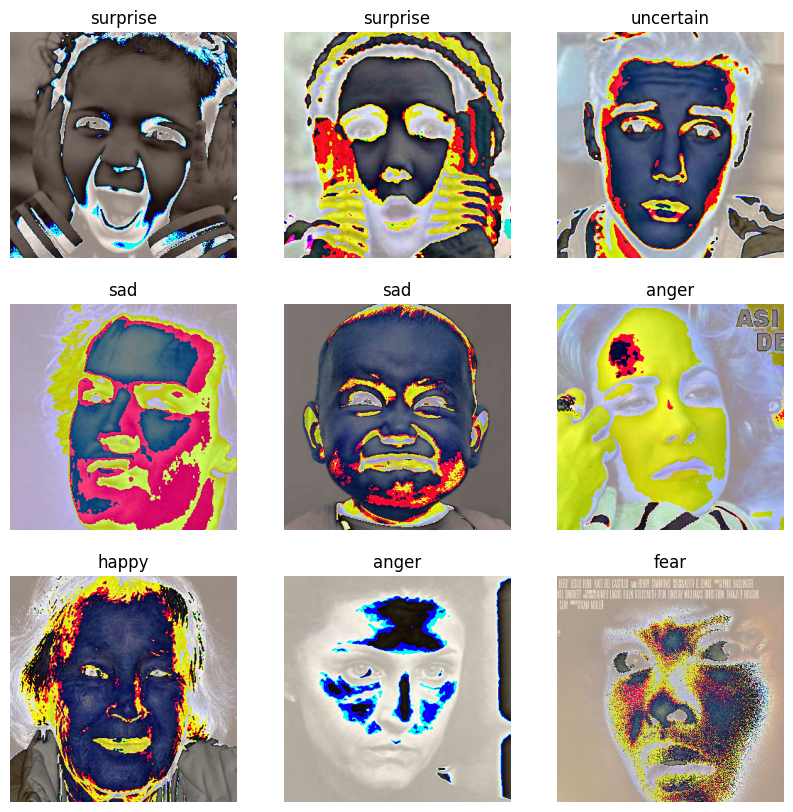

In [11]:
# Cheking preprocessed data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.math.argmax(labels, axis=1)[i]])
        plt.axis("off")

### Creating a model

In [23]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [24]:
augmentation_layer = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                          tf.keras.layers.RandomRotation(0.1),
                                          tf.keras.layers.RandomContrast(0.1)])
normalization_layer = tf.keras.layers.Rescaling(1./255)    

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = augmentation_layer(inputs)
x = normalization_layer(x)
x = base_model(x, training=False)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model_02_norm_aug = tf.keras.Model(inputs, outputs)

In [25]:
model_02_norm_aug.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 320, 320, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 320, 320, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 average_pooling2d_2 (Averag  (None, 5, 5, 2048)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                           

In [26]:
# Function for model compile
def model_compile(model, lr):
    model = model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                          loss='categorical_crossentropy',
                          metrics=['categorical_accuracy'])
    return model

In [27]:
LR = 1e-4
EPOCHS = 20

model_compile(model_02_norm_aug, LR)

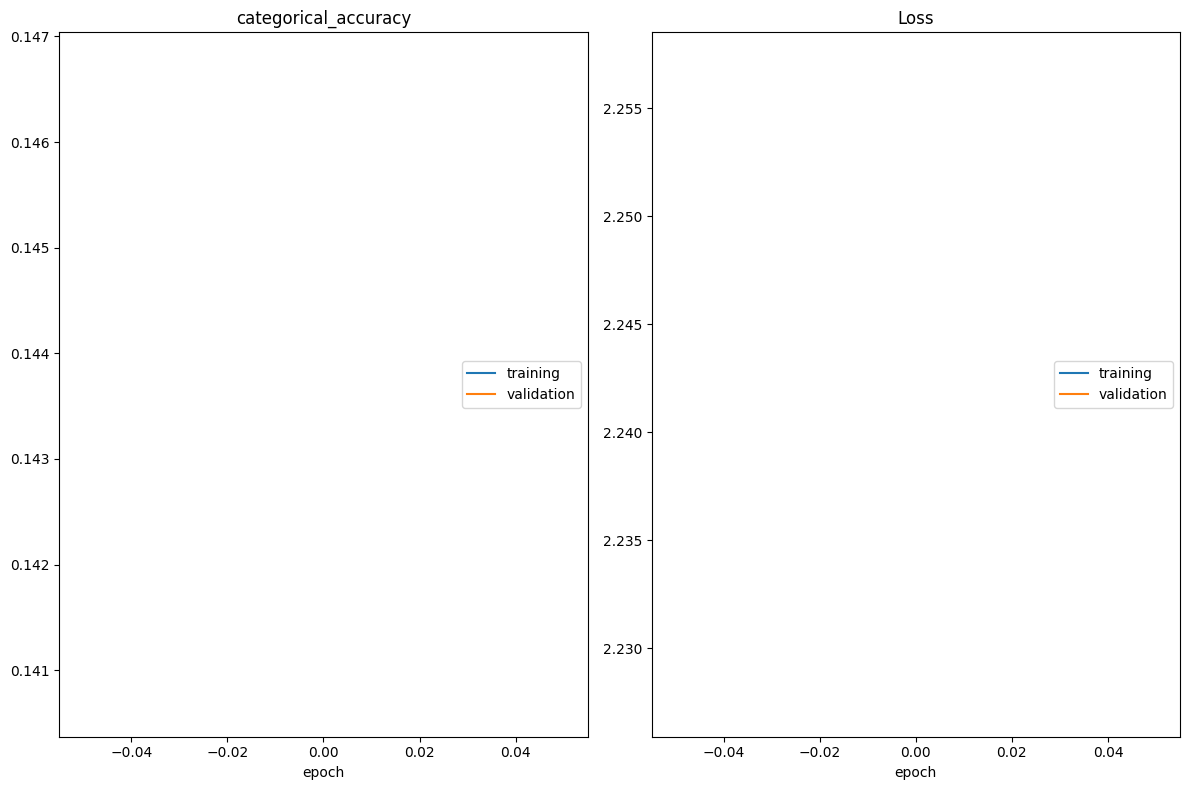

categorical_accuracy
	training         	 (min:    0.147, max:    0.147, cur:    0.147)
	validation       	 (min:    0.141, max:    0.141, cur:    0.141)
Loss
	training         	 (min:    2.257, max:    2.257, cur:    2.257)
	validation       	 (min:    2.227, max:    2.227, cur:    2.227)
1252/1252 [==============================] - 241s 190ms/step - loss: 2.2570 - categorical_accuracy: 0.1467 - val_loss: 2.2274 - val_categorical_accuracy: 0.1407
Epoch 2/20
 511/1252 [===========>..................] - ETA: 1:51 - loss: 2.1757 - categorical_accuracy: 0.1490

In [ ]:
history_02_norm_aug = model_02_norm_aug.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

<b>Categorical accuracy is lower than in the first attempt.</b>

In [ ]:
base_model.trainable = True

NON_TRAINABLE_LAYERS = 140
for layer in base_model.layers[:NON_TRAINABLE_LAYERS]:
    layer.trainable = False

In [ ]:
LR = 1e-5
EPOCHS = 20

model_compile(model_02_norm_aug, LR)

In [ ]:
history_02_norm_aug = model_02_norm_aug.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

<b>Categorical accuracy increased, but after 20 epochs we gave overfit again. To reduse overfitting we could add Dropout layer.</b>

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [ ]:
augmentation_layer = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                          tf.keras.layers.RandomRotation(0.1),
                                          tf.keras.layers.RandomContrast(0.1)])
normalization_layer = tf.keras.layers.Rescaling(1./255)    

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = augmentation_layer(inputs)
x = normalization_layer(x)
x = base_model(x, training=False)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model_02_norm_aug = tf.keras.Model(inputs, outputs)

In [ ]:
model_02_norm_aug.summary()

In [ ]:
LR = 1e-4
EPOCHS = 20

model_compile(model_02_norm_aug, LR)

In [ ]:
history_02_norm_aug = model_02_norm_aug.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

In [ ]:
base_model.trainable = True

NON_TRAINABLE_LAYERS = 140
for layer in base_model.layers[:NON_TRAINABLE_LAYERS]:
    layer.trainable = False

In [ ]:
LR = 1e-5
EPOCHS = 20

model_compile(model_02_norm_aug, LR)

In [ ]:
history_02_norm_aug = model_02_norm_aug.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])